In [3]:
%pylab inline
from sshtunnel import SSHTunnelForwarder
import pymongo
import os
import stat
import json
import datetime
import paramiko
import pandas

pkey=os.path.join(os.environ['HOME'],'.ssh/id_rsa')
key=paramiko.RSAKey.from_private_key_file(pkey)

MONGO_HOST = "129.94.162.112"
MONGO_USER = "goios"
MONGO_DB = "test2"
MONGO_COLLECTION = "ls-remote"
local_port = 26017

# define ssh tunnel
with SSHTunnelForwarder(
    MONGO_HOST,
    ssh_username=MONGO_USER,
    ssh_pkey=key,
    remote_bind_address=('localhost', 27017),
    local_bind_address=('localhost',local_port)
) as server:
    connection = pymongo.MongoClient('localhost', local_port)
    db = connection[MONGO_DB]
    collection = db[MONGO_COLLECTION]
    
    collection.drop()

    for f in os.listdir('.'):
        collection.insert_one({'name':f, 
                               'time': {'access': datetime.datetime.fromtimestamp(os.stat(f).st_atime), 
                                        'modification': datetime.datetime.fromtimestamp(os.stat(f).st_mtime)},
                               'size':os.stat(f).st_size,
                               'directory':stat.S_ISDIR(os.stat(f).st_mode)})
    #print (db)
    #print(json.dumps(db.list_collection_names(), indent=2))    

    # close ssh tunnel
    connection.close()
    server.stop()

Populating the interactive namespace from numpy and matplotlib


In [4]:
connection.close()
server.stop()

In [5]:
MONGO_DB = "modal-2duct-simulations"
#MONGO_DB = "test2"
MONGO_COLLECTION = "random-runs-1"
MONGO_COLLECTION = "random-runs-var-gamma"
MONGO_COLLECTION = "modal-vt-bore-var-gamma-nlstiff"
with SSHTunnelForwarder(    
    MONGO_HOST,
    ssh_username=MONGO_USER,
    ssh_pkey="~/.ssh/id_rsa",
    remote_bind_address=('localhost', 27017),
    local_bind_address=('localhost',local_port)
) as server:
    with pymongo.MongoClient('localhost', local_port) as connection:
        db = connection[MONGO_DB]
        collection = db[MONGO_COLLECTION]
        print (db)
        print(json.dumps(connection.list_database_names(),indent=2))
        print(json.dumps(db.list_collection_names(), indent=2))    


Database(MongoClient(host=['localhost:26017'], document_class=dict, tz_aware=False, connect=True), 'modal-2duct-simulations')
[
  "admin",
  "config",
  "local",
  "modal-2duct-simulations",
  "test1",
  "test2"
]
[
  "random-runs-var-gamma",
  "random-runs-1",
  "random-runs-var-gamma-pert-time",
  "modal-tests",
  "modal-vt-bore-var-gamma-nlstiff"
]


In [6]:
with SSHTunnelForwarder(    
    MONGO_HOST,
    ssh_username=MONGO_USER,
    ssh_pkey="~/.ssh/id_rsa",
    remote_bind_address=('localhost', 27017),
    local_bind_address=('localhost',local_port)
) as server:
    with pymongo.MongoClient('localhost', local_port) as connection:
        db = connection[MONGO_DB]
        collection = db[MONGO_COLLECTION]
        #collection.drop()
        print(collection.count())
        print(json.dumps(db.command("dbstats"),indent=2))
#         for d in collection.find():
#             err = "Ok"
#             try:
#                 d['simulation']['error']
#                 err='Error in simulation'
#             except KeyError:
#                 pass
#             try:
#                 d['analysis']['error']
#                 err='Error in analysis'
#             except KeyError:
#                 pass
                
#             print(d['_id'],d['simulation']['start'],d['simulation']['end'],err)
        ll = list(collection.find({'simulation.params.gamma.sustain_val': {'$gt':.4, '$lt':.65}}))
    print(len(ll))

33988
{
  "db": "modal-2duct-simulations",
  "collections": 5,
  "views": 0,
  "objects": 151715,
  "avgObjSize": 3526.50835448044,
  "dataSize": 535024215.0,
  "storageSize": 311558144.0,
  "numExtents": 0,
  "indexes": 5,
  "indexSize": 2863104.0,
  "fsUsedSize": 26666749952.0,
  "fsTotalSize": 44780494848.0,
  "ok": 1.0
}
10004


In [7]:
import six

def list_dict_items(obj):
    try:
        for k, v in obj.items():
            yield k, v
    except AttributeError:
        if not isinstance(obj, six.string_types):
            for k, v in enumerate(obj):
                yield k, v

def json_flatten(js,root=""):
    try:
        for k,v in list_dict_items(js):
            yield from json_flatten(v,root=root+"/"+str(k))
    except TypeError:
        yield root[1:], js

def json_array_flatten(js):
    for ii, el in enumerate(js):
        yield {k:v for k,v in json_flatten(el)}
    

In [8]:
{k:v for k,v in json_flatten({'a':1,'b':[0,2,{'a':-1,"b":"hello"}]})}

{'a': 1, 'b/0': 0, 'b/1': 2, 'b/2/a': -1}

In [9]:
df=pandas.DataFrame(json_array_flatten(ll))

In [10]:
df['gets larger than perturbation'] = df['analysis/hb1_abs_fin'] > df['analysis/hb1_abs_pert']

In [11]:
df['finishes close to max'] = df['analysis/hb1_abs_fin'] > df['analysis/hb1_abs_max']/2

In [12]:
df['trans dur']=df['analysis/t_trans_end']-df['analysis/t_trans_start']

In [13]:
df['starts after pert'] = df['analysis/t_trans_start'] - df['analysis/pert_time'] >-0.002
df['starts after pert'].value_counts()

True     6275
False    3729
Name: starts after pert, dtype: int64

In [14]:
df.pivot_table(index='finishes close to max', columns='gets larger than perturbation', values='analysis/f0', aggfunc='count')

gets larger than perturbation,False,True
finishes close to max,,
False,36,443
True,1349,8176


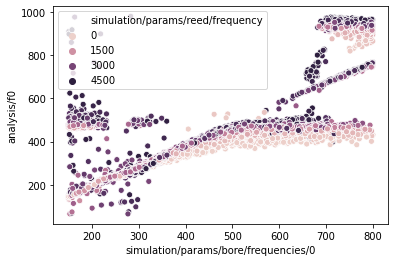

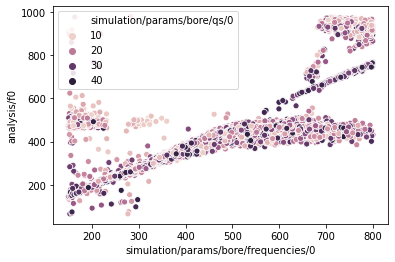

In [15]:
import seaborn as sns
sns.scatterplot(data=df,x='simulation/params/bore/frequencies/0',y='analysis/f0',hue='simulation/params/reed/frequency')
figure()
sns.scatterplot(data=df,x='simulation/params/bore/frequencies/0',y='analysis/f0',hue='simulation/params/bore/qs/0')

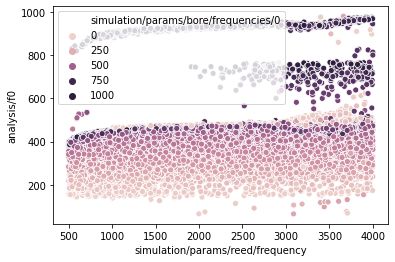

In [16]:
import seaborn as sns
sns.scatterplot(data=df,x='simulation/params/reed/frequency',y='analysis/f0',hue='simulation/params/bore/frequencies/0')

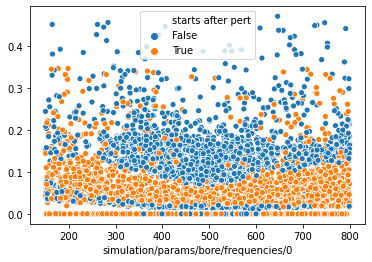

In [17]:
import seaborn as sns
sns.scatterplot(data=df,x='simulation/params/bore/frequencies/0',y=df['analysis/t_trans_end']-df['analysis/t_trans_start'],hue='starts after pert')

In [18]:
df1 = df[df['starts after pert'] & (df['trans dur']>0.001)]

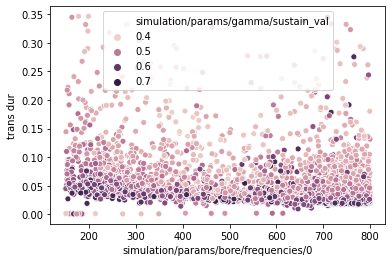

In [19]:
import seaborn as sns
sns.scatterplot(data=df1,x='simulation/params/bore/frequencies/0',y='trans dur',hue='simulation/params/gamma/sustain_val')

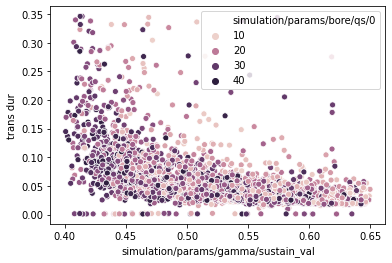

In [20]:
sns.scatterplot(data=df1,hue='simulation/params/bore/qs/0',y='trans dur',x='simulation/params/gamma/sustain_val')

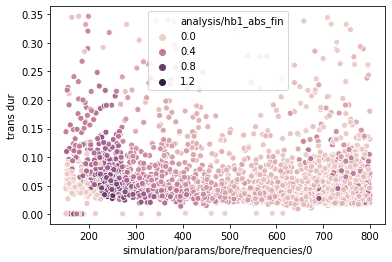

In [21]:
sns.scatterplot(data=df1,x='simulation/params/bore/frequencies/0',y='trans dur',hue='analysis/hb1_abs_fin')

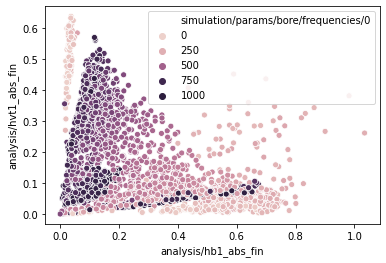

In [22]:
sns.scatterplot(data=df1,y='analysis/hvt1_abs_fin',x='analysis/hb1_abs_fin',hue='simulation/params/bore/frequencies/0')

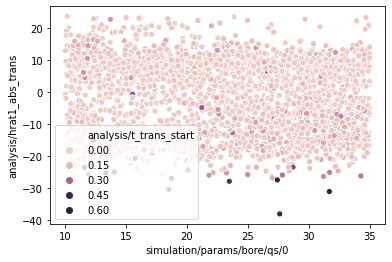

In [23]:
sns.scatterplot(data=df1,hue='analysis/t_trans_start',y='analysis/hrat1_abs_trans',x='simulation/params/bore/qs/0')

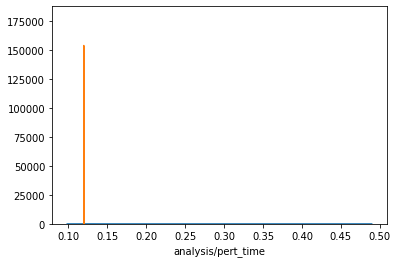

In [24]:
sns.distplot(df1['analysis/t_trans_start'],norm_hist=False)
sns.distplot(df1['analysis/pert_time'],norm_hist=False)

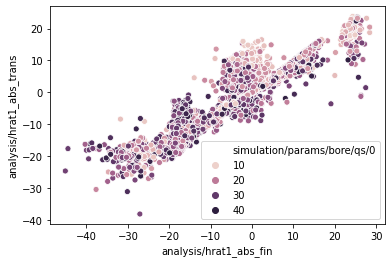

In [25]:
sns.scatterplot(data=df1,x='analysis/hrat1_abs_fin',y='analysis/hrat1_abs_trans',hue='simulation/params/bore/qs/0')

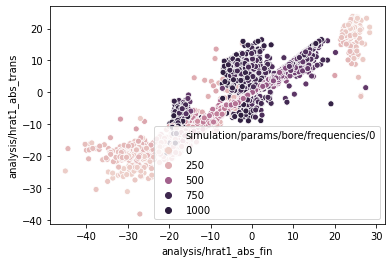

In [26]:
sns.scatterplot(data=df1,x='analysis/hrat1_abs_fin',y='analysis/hrat1_abs_trans',hue='simulation/params/bore/frequencies/0')

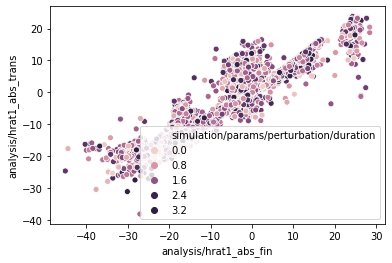

In [27]:
sns.scatterplot(data=df1,x='analysis/hrat1_abs_fin',y='analysis/hrat1_abs_trans',hue='simulation/params/perturbation/duration')

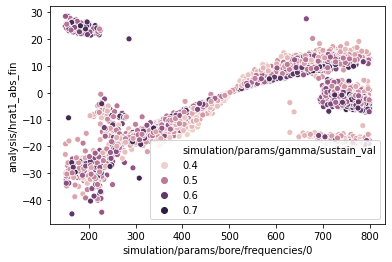

In [28]:
sns.scatterplot(data=df1,y='analysis/hrat1_abs_fin',hue='simulation/params/gamma/sustain_val',x='simulation/params/bore/frequencies/0')

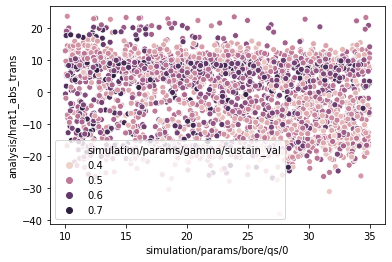

In [29]:
sns.scatterplot(data=df1,y='analysis/hrat1_abs_trans',hue='simulation/params/gamma/sustain_val',x='simulation/params/bore/qs/0')

In [362]:
{col:len(df[col].unique())for col in df.columns}

{'_id': 1923,
 'simulation/start': 1923,
 'simulation/params/tmax': 1,
 'simulation/params/gamma/sustain_val': 1923,
 'simulation/params/gamma/time_const': 1,
 'simulation/params/gamma/exp_limit_multiplier': 1,
 'simulation/params/zeta': 1,
 'simulation/params/reed/frequency': 1923,
 'simulation/params/reed/q': 1923,
 'simulation/params/reed/amplitude': 1923,
 'simulation/params/bore/frequencies/0': 1923,
 'simulation/params/bore/qs/0': 1923,
 'simulation/params/bore/amplitudes/0': 1923,
 'simulation/params/vocal/frequencies/0': 1,
 'simulation/params/vocal/qs/0': 1,
 'simulation/params/vocal/amplitudes/0': 1,
 'simulation/params/nlfunc/nl_start': 1,
 'simulation/params/nlfunc/nl_ev': 1,
 'simulation/params/perturbation/multiplier': 1,
 'simulation/params/perturbation/duration': 1923,
 'simulation/params/simulation/sample rate': 1923,
 'simulation/end': 1923,
 'analysis/pert_time': 1923,
 'analysis/initial amplitude': 1923,
 'analysis/final amplitude': 1923,
 'analysis/f0': 1923,
 'ana

In [5]:
start = datetime.datetime(2020, 1, 1, 0, 0, 0, 0)
#end = datetime.datetime(2012, 2, 2, 6, 55, 3, 381)

    
with SSHTunnelForwarder(    
    MONGO_HOST,
    ssh_username=MONGO_USER,
    ssh_pkey="~/.ssh/id_rsa",
    remote_bind_address=('localhost', 27017),
    local_bind_address=('localhost',local_port)
) as server:
    with pymongo.MongoClient('localhost', local_port) as connection:
        db = connection[MONGO_DB]
        collection = db[MONGO_COLLECTION]

        #for f in os.listdir('.'):
        #    collection.insert_one({'name':f, 'time':os.stat(f).st_mtime, 'size':os.stat(f).st_size})
        for doc in collection.find({'time.modification':{'$gte': start}}):
            print(json.dumps(doc,default=str,indent=2))


{
  "_id": "5f7d4f11de28f7d78d65b0fc",
  "name": "nb_runner",
  "time": {
    "access": "2020-10-07 11:41:20.387000",
    "modification": "2020-01-03 12:50:36.377000"
  },
  "size": 4096,
  "directory": true
}
{
  "_id": "5f7d4f11de28f7d78d65b101",
  "name": "__pycache__",
  "time": {
    "access": "2020-10-06 18:19:13.725000",
    "modification": "2020-10-06 18:06:44.259000"
  },
  "size": 4096,
  "directory": true
}
{
  "_id": "5f7d4f11de28f7d78d65b107",
  "name": "xrandr.py",
  "time": {
    "access": "2020-10-06 10:59:46.768000",
    "modification": "2020-08-24 10:15:53.423000"
  },
  "size": 7250,
  "directory": false
}
{
  "_id": "5f7d4f11de28f7d78d65b10e",
  "name": ".ipynb_checkpoints",
  "time": {
    "access": "2020-10-07 11:41:20.387000",
    "modification": "2020-10-06 18:23:25.454000"
  },
  "size": 4096,
  "directory": true
}
{
  "_id": "5f7d4f11de28f7d78d65b117",
  "name": ".pcloud_note.py.un~",
  "time": {
    "access": "2020-07-14 21:43:26.097000",
    "modification": 